# Amazon Comprehend and Sagemaker Linear Leraning for document tag extraction

This example shows how documents can be tagged trough a combination of Amazon Comprehend and Sagemaker Linear Learner models that does a further classification.

The code here is for illusration purpuses. Furthe fine-tuning to the model can be done. The final part of the process around inference and tag extraction is well-suited for implemenation in Lambda 

In [1]:
import numpy as np
import boto3
import json
import pandas as pd
import time
#from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.model_selection import train_test_split
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import io
import os
#from sagemaker.predictor import csv_serializer
#from sagemaker.predictor import json_serializer, json_deserializer


In [2]:

def createBucket(bucketname):
    s3 = boto3.client('s3')
    response = s3.list_buckets()
    existingbuckets = [d['Name'] for d in response["Buckets"]]
    #print(existingbuckets)
    if bucketname not in existingbuckets:
        print("creating bucket " + bucketname)
        s3.create_bucket(Bucket=bucketname)
    else:
        print("bucket exists! " + bucketname)

### Create bucket if it does not exist

In [3]:
accountid = boto3.client('sts').get_caller_identity().get('Account')
bucketname = "aimlbootcamp" + accountid
createBucket(bucketname)

bucket exists! aimlbootcamp247322960887


### Explore the training data set

We started off with a small dataset (300 cases) of keyphrases that were classified as 'good' or or 'bad' keyphrases for tagging purposes. An example of a good phrase is 'artificial intelligence' while something like 'this year' is considered to be a poor tag choice.


In [4]:
names = ['keyphrase', 'class']
datain = pd.read_csv('keyphrase-classes.csv', names=names)


In [5]:
print(datain.head())

                 keyphrase  class
0  artificial intelligence      1
1         machine learning      1
2                this year      0
3    blockchain technology      1
4                last year      0


### Next we are doing an experiment

Comprehend can evaluate a phrase like 'artificial intelligence' and determine what part of speech each word is.

We are going to do this excercise on the entire tyraining dataset to count the occurences of Pronouns, Verb, Nouns, etc for each keyphrase.

We are goping to then turn the counts for each part of speech into a vector. We are going to see if we can use this to predict whether a phrase makes a good tag or not.

In [6]:
def getSyntaxTokensFeatureVector(text, tagList = ['PRON', 'CONJ', 'NUM', 'VERB', 'ADP', 'DET', 'ADV', 'PART', 'PROPN', 'SYM', 'PUNCT', 'ADJ', 'AUX', 'NOUN', 'SCONJ']):
    
    tagDictionary = {} #creating a dictionary for fast lookup 
    for i in range(0,len(tagList)):
        tagDictionary[tagList[i]] = i
    #print("tagDictionary: ", tagDictionary)
    
    featureVector = np.zeros(len(tagList)) #create a vectot for the featurs
    #print("featureVector: ", featureVector)
    client = boto3.client('comprehend') 
    language = 'en'
    response = client.detect_syntax(
            Text=text,
            LanguageCode=language
        )    
    #print(json.dumps(response, indent=2))
    tags = ""
    for SyntaxToken in response["SyntaxTokens"]:
        thisTag = SyntaxToken["PartOfSpeech"]["Tag"]
        thisScore = SyntaxToken["PartOfSpeech"]["Score"]
        if thisScore > 0.95 and thisTag in tagList: #only take ones we are at least 95% confident with and tags we are using as features
            tags += "," + thisTag
            index = tagDictionary[thisTag]
            featureVector[index] = featureVector[index] + 1

    #print("updated Feature Vector: ", featureVector)
        
    return tags, response, featureVector


### We initialli started with a long list of parts of speech, but after plotting historgrams we only took the ones that showed variance.

Here we do a little excercise in showing you what the parts of speech and the resulting vector looks like.

In [7]:
#tagList = ['PRON', 'CONJ', 'NUM', 'VERB', 'ADP', 'DET', 'ADV', 'PART', 'PROPN', 'SYM', 'PUNCT', 'ADJ', 'AUX', 'NOUN', 'SCONJ']
tagList = ['PRON', 'CONJ', 'NUM', 'VERB', 'DET', 'PROPN', 'SYM', 'PUNCT', 'ADJ', 'NOUN']

myText = "The donkey or ass (Equus africanus asinus)[1][2] is a domesticated member of the horse family, Equidae. The wild ancestor of the donkey is the African wild ass, E. africanus. The donkey has been used as a working animal for at least 5000 years. There are more than 40 million donkeys in the world, mostly in underdeveloped countries, where they are used principally as draught or pack animals. Working donkeys are often associated with those living at or below subsistence levels. Small numbers of donkeys are kept for breeding or as pets in developed countries. A male donkey or ass is called a jack, a female a jenny or jennet;[3][4][5] a young donkey is a foal.[5] Jack donkeys are often used to mate with female horses to produce mules; the biological 'reciprocal' of a mule, from a stallion and jenny as its parents instead, is called a hinny. Asses were first domesticated around 3000 BC, probably in Egypt or Mesopotamia,[6][7] and have spread around the world. They continue to fill important roles in many places today. While domesticated species are increasing in numbers, the African wild ass is an endangered species. As beasts of burden and companions, asses and donkeys have worked together with humans for millennia."

tags, response, featureVector = getSyntaxTokensFeatureVector(myText, tagList)
print("tags: ", tags)
print("featurevector: ", featureVector)

tags:  ,DET,NOUN,CONJ,PUNCT,PUNCT,VERB,DET,NOUN,DET,NOUN,NOUN,PUNCT,PROPN,PUNCT,DET,ADJ,NOUN,DET,NOUN,VERB,DET,ADJ,NOUN,PUNCT,PUNCT,DET,NOUN,VERB,DET,NOUN,NUM,NOUN,PUNCT,PRON,VERB,ADJ,NUM,NUM,NOUN,DET,NOUN,PUNCT,NOUN,PUNCT,PRON,VERB,CONJ,NOUN,PUNCT,NOUN,VERB,VERB,CONJ,NOUN,PUNCT,ADJ,NOUN,NOUN,VERB,CONJ,NOUN,NOUN,PUNCT,DET,NOUN,CONJ,NOUN,VERB,DET,NOUN,PUNCT,DET,DET,NOUN,CONJ,NOUN,PUNCT,NUM,DET,ADJ,NOUN,VERB,DET,NOUN,PUNCT,NUM,PROPN,NOUN,VERB,VERB,ADJ,NOUN,VERB,NOUN,PUNCT,DET,PUNCT,DET,NOUN,PUNCT,DET,NOUN,CONJ,NOUN,PRON,NOUN,PUNCT,VERB,DET,NOUN,PUNCT,VERB,NUM,PUNCT,PROPN,CONJ,PROPN,PUNCT,NUM,NUM,CONJ,VERB,DET,NOUN,PUNCT,PRON,VERB,VERB,ADJ,NOUN,ADJ,NOUN,NOUN,PUNCT,NOUN,VERB,NOUN,PUNCT,DET,ADJ,NOUN,VERB,DET,NOUN,PUNCT,NOUN,NOUN,CONJ,NOUN,PUNCT,NOUN,CONJ,NOUN,VERB,NOUN,NOUN,PUNCT
featurevector:  [ 4. 11.  8. 21. 22.  4.  0. 28.  9. 50.]


### Here we try a more realistic example of what we would do on keyphrases

In [8]:
myText = "autonomous vehicles"

tags, response, featureVector = getSyntaxTokensFeatureVector(myText, tagList)
print("tags: ", tags)
print("featurevector: ", featureVector)

tags:  ,ADJ,NOUN
featurevector:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


### Let's run this on our entire training dataset

So what we are doing to to calculate the feature vector for each observation and creating a dataset that will be ready for training.

In [9]:
dataset = None
for index, row in datain.iterrows():
    #print(row['keyphrase'], row['class'])
    keyphrase = row['keyphrase']
    thisclass = row['class']
    tags, response, featureVector = getSyntaxTokensFeatureVector(keyphrase, tagList)
    #print(keyphrase)
    #print("features: ", featureVector)
    thisRow = np.append(featureVector, thisclass)
    if type(dataset) == type(None):
        dataset = thisRow
    else:
        dataset = np.vstack((dataset,thisRow))



   

### Here we have a look at what the dataset looks like

In [10]:
print("data set: ", dataset)
print("dataset.shape: ", dataset.shape) 
numrows, numcols = dataset.shape
print(numrows, numcols)

data set:  [[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
dataset.shape:  (303, 11)
303 11


### We add the column names, split into train and test sets

In [11]:
# split into input (X) and output (y) variables
print("tagList: ", tagList)
X = dataset[:,0:numcols-1]
y = dataset[:,numcols-1]
colnames = list(tagList)
print("colnames1: ", colnames)
colnames.append("class")

print("colnames: ", colnames)
data = pd.DataFrame(data=dataset)
data.columns = colnames
print(X)

tagList:  ['PRON', 'CONJ', 'NUM', 'VERB', 'DET', 'PROPN', 'SYM', 'PUNCT', 'ADJ', 'NOUN']
colnames1:  ['PRON', 'CONJ', 'NUM', 'VERB', 'DET', 'PROPN', 'SYM', 'PUNCT', 'ADJ', 'NOUN']
colnames:  ['PRON', 'CONJ', 'NUM', 'VERB', 'DET', 'PROPN', 'SYM', 'PUNCT', 'ADJ', 'NOUN', 'class']
[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("X_train: ", X_train[:10])
print("X_Test: ", X_test[:10])

X_train:  [[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]]
X_Test:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### We do some plots. The goal is to elimate some parts of speech that don't show variation.

If anything needs to be added or removed, update the list *tagList* above


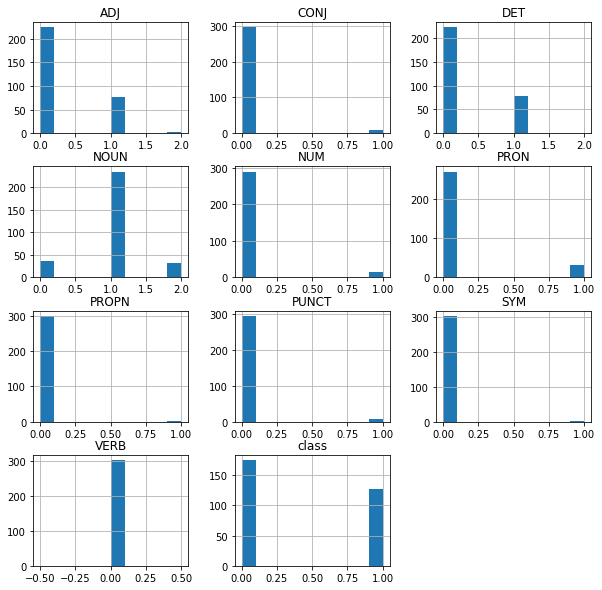

In [13]:
thisplot = data.hist(figsize=(10,10))

### Next we write the train and test sets to S3 ready for our linear model

In [14]:
prefix = "document-tag-keyphrase-classifier"

In [15]:
#numpy.savetxt("foo.csv", a, delimiter=",")
train_file = 'linear_train.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_train.astype('float32'), y_train.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucketname).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)


In [16]:
validation_file = 'linear_validation.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_test.astype('float32'), y_test.astype('float32'))
f.seek(0)

#X_train, X_test, y_train, y_test

boto3.Session().resource('s3').Bucket(bucketname).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)

### We get ready to do training

In [17]:
# See 'Algorithms Provided by Amazon SageMaker: Common Parameters' in the SageMaker documentation for an explanation of these values.

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [18]:
linear_job = 'DEMO-linear-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", linear_job)

role = get_execution_role()

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucketname, prefix),
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucketname, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucketname, prefix)
    },
    "HyperParameters": {
        "feature_dim": str(numcols-1),
        "mini_batch_size": "100",
        "predictor_type": "binary_classifier",
        "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

Job name is: DEMO-linear-2019-11-24-02-01-12


### Kick off the training job. It should take about six minutes to complete

In [19]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**linear_training_params)

status = sm.describe_training_job(TrainingJobName=linear_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=linear_job)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=linear_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
CPU times: user 79.6 ms, sys: 4 ms, total: 83.6 ms
Wall time: 4min


### We create the model

The artifacts would have been stored on S3 after training

In [20]:
modelartifacts = sm.describe_training_job(TrainingJobName=linear_job)['ModelArtifacts']['S3ModelArtifacts']
print("model afrtifacts: ", modelartifacts)

model afrtifacts:  s3://aimlbootcamp247322960887/document-tag-keyphrase-classifier/DEMO-linear-2019-11-24-02-01-12/output/model.tar.gz


In [21]:
linear_hosting_container = {
    'Image': container,
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=linear_job)['ModelArtifacts']['S3ModelArtifacts']
}

create_model_response = sm.create_model(
    ModelName=linear_job,
    ExecutionRoleArn=role,
    PrimaryContainer=linear_hosting_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:247322960887:model/demo-linear-2019-11-24-02-01-12


In [22]:
linear_endpoint_config = 'DEMO-linear-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(linear_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=linear_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m5.large',
        'InitialInstanceCount': 1,
        'ModelName': linear_job,
        'VariantName': 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-linear-endpoint-config-2019-11-24-02-05-12
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:247322960887:endpoint-config/demo-linear-endpoint-config-2019-11-24-02-05-12


### We create an endpoint

In [23]:
%%time

linear_endpoint = 'DEMO-linear-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(linear_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=linear_endpoint,
    EndpointConfigName=linear_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=linear_endpoint)

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

DEMO-linear-endpoint-201911240205
arn:aws:sagemaker:us-east-1:247322960887:endpoint/demo-linear-endpoint-201911240205
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:247322960887:endpoint/demo-linear-endpoint-201911240205
Status: InService
CPU times: user 207 ms, sys: 4.8 ms, total: 212 ms
Wall time: 7min 31s


### A little function to convert numpy arrays to CSV which is useful for invoking the endpoint

In [24]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

### We now do inference on the test data set by invoking the endpoint

In [25]:
#X_train, X_test, y_train, y_test
runtime= boto3.client('runtime.sagemaker')

payload = np2csv(X_test)
response = runtime.invoke_endpoint(EndpointName=linear_endpoint,
                                   ContentType='text/csv',
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
test_pred = np.array([r['score'] for r in result['predictions']])

In [26]:
test_mae_linear = np.mean(np.abs(y_test - test_pred))
test_mae_baseline = np.mean(np.abs(y_test - np.median(y_train))) ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear,3))

Test MAE Baseline : 0.51
Test MAE Linear: 0.439


### now we look at the accuracy.

We still have some work to do to improve accuracy

In [27]:
test_pred_class = (test_pred > 0.5)+0;
test_pred_baseline = np.repeat(np.median(y_train), len(y_test))

prediction_accuracy = np.mean((y_test== test_pred_class))*100
baseline_accuracy = np.mean((y_test == test_pred_baseline))*100

print("Prediction Accuracy:", round(prediction_accuracy,1), "%")
print("Baseline Accuracy:", round(baseline_accuracy,1), "%")

Prediction Accuracy: 54.0 %
Baseline Accuracy: 49.0 %


### Some functions to call Amazon Comprehend 

In [28]:
def detect_dominant_language(text):
    client = boto3.client('comprehend')
    response = client.detect_dominant_language(
        Text=text
    )    
    language = response["Languages"][0]["LanguageCode"]
    #print("language: ", language )
    #print("languages: ", response)
    return language

def detect_entities(text):
    client = boto3.client('comprehend')
    language = detect_dominant_language(text)
    response = client.detect_entities(Text=text, LanguageCode=language)
    #print(json.dumps(response, indent=2))
    return response
    #print(response)

def detect_key_phrases(text):
    client = boto3.client('comprehend') 
    language = detect_dominant_language(text)
    response = client.detect_key_phrases(
            Text=text,
            LanguageCode=language
        )    
    #print(json.dumps(response, indent=2))
    return response    
    
def detect_sentiment(text):
    client = boto3.client('comprehend') 
    language = detect_dominant_language(text)
    response = client.detect_sentiment(
            Text=text,
            LanguageCode=language
        )    
    #print(json.dumps(response, indent=2))
    return response      

def detect_syntax(text):
    client = boto3.client('comprehend') 
    language = detect_dominant_language(text)
    response = client.detect_syntax(
            Text=text,
            LanguageCode=language
        )    
    #print(json.dumps(response, indent=2))
    return response
    

In [29]:
def makeCSVFormat(oneRowArray):
    outputval = ""
    for item in oneRowArray:
        if outputval == "":
            outputval = str(item)
        else:
            outputval += "," + str(item)
    return outputval

### Given some text and the model endpoint, this will give us a prediction if the text makes a good tag or not

In [30]:
def predictIfRelevantPhrase(text, modelendpoint):
    tags, response, featureVector = getSyntaxTokensFeatureVector(text, tagList)
    csvformattedVal = makeCSVFormat(featureVector)
    response = runtime.invoke_endpoint(EndpointName=modelendpoint,
                                   ContentType='text/csv',
                                   Body=csvformattedVal)

    result = json.loads(response['Body'].read().decode())
    score = result["predictions"][0]["score"]
    predictedLabel = result["predictions"][0]["predicted_label"]
    
    print("result: ", result, " ::: ", text)
    return predictedLabel, score
    

### The main function to extract tags from documents

It relies on Comprehend entity extraction. It only looks at some of the categories by ignoring categories that are prone to generating noise.
For keyphrases we use our linear learner model to discard bad tags

In [31]:
def getDocTags(document, modelendpoint):
    entities = detect_entities(document)
    myTags = []
    for entity in entities["Entities"]:
        if entity["Type"] in ['PERSON', 'LOCATION', 'ORGANIZATION', 'COMMERCIAL_ITEM', 'EVENT', 'QUANTITY', 'TITLE', 'OTHER']:
            thisEntity = entity["Text"]
            myTags.append(thisEntity)
    keyphrases = detect_key_phrases(document)
    for keyphrase in keyphrases["KeyPhrases"]:
        thisPhrase = keyphrase["Text"]
        if thisPhrase not in myTags and " " in thisPhrase: #avoid double add. Only add multi-word items
            prediction, score = predictIfRelevantPhrase(thisPhrase, modelendpoint)
            if score > 0: #we can potentially adjust this value
                myTags.append(thisPhrase)
    return myTags

In [32]:
myText = "The donkey or ass (Equus africanus asinus)[1][2] is a domesticated member of the horse family, Equidae. The wild ancestor of the donkey is the African wild ass, E. africanus. The donkey has been used as a working animal for at least 5000 years. There are more than 40 million donkeys in the world, mostly in underdeveloped countries, where they are used principally as draught or pack animals. Working donkeys are often associated with those living at or below subsistence levels. Small numbers of donkeys are kept for breeding or as pets in developed countries. A male donkey or ass is called a jack, a female a jenny or jennet;[3][4][5] a young donkey is a foal.[5] Jack donkeys are often used to mate with female horses to produce mules; the biological 'reciprocal' of a mule, from a stallion and jenny as its parents instead, is called a hinny. Asses were first domesticated around 3000 BC, probably in Egypt or Mesopotamia,[6][7] and have spread around the world. They continue to fill important roles in many places today. While domesticated species are increasing in numbers, the African wild ass is an endangered species. As beasts of burden and companions, asses and donkeys have worked together with humans for millennia."
myTags = getDocTags(myText, linear_endpoint)
print("### TAGS ###: ",  myTags)

result:  {'predictions': [{'score': 0.7861346006393433, 'predicted_label': 1.0}]}  :::  The donkey or ass
result:  {'predictions': [{'score': -0.0023279674351215363, 'predicted_label': 1.0}]}  :::  a domesticated member
result:  {'predictions': [{'score': 0.08459353446960449, 'predicted_label': 1.0}]}  :::  the horse family
result:  {'predictions': [{'score': 0.010069046169519424, 'predicted_label': 1.0}]}  :::  The wild ancestor
result:  {'predictions': [{'score': -0.0023279674351215363, 'predicted_label': 1.0}]}  :::  the donkey
result:  {'predictions': [{'score': 0.010069046169519424, 'predicted_label': 1.0}]}  :::  the African wild ass
result:  {'predictions': [{'score': 0.03632922098040581, 'predicted_label': 1.0}]}  :::  E. africanus
result:  {'predictions': [{'score': -0.0023279674351215363, 'predicted_label': 1.0}]}  :::  The donkey
result:  {'predictions': [{'score': -0.0023279674351215363, 'predicted_label': 1.0}]}  :::  a working animal
result:  {'predictions': [{'score': -0

### Import to delete the endpoint when done. Otherwise there are ongoing charges


In [33]:
sm.delete_endpoint(EndpointName=linear_endpoint)

{'ResponseMetadata': {'RequestId': '84ab0367-fb68-4dfa-a21d-ed7032b4c658',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '84ab0367-fb68-4dfa-a21d-ed7032b4c658',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 24 Nov 2019 02:12:48 GMT'},
  'RetryAttempts': 0}}

### Further implementation steps

A the inference part can be implemented in a Lambda function which can then be easily integrated in a data pipeline. For example, when a document arrives in S3, the pipeline gets trigered which extracts the tags (combination of Comprehend entity extraction + Comprehend keyphrases + linear learner classifier). The resulting output can then be placed in S3, DynammDB, Neptune (for graphs) or in ElasticSearch.
